In [321]:
# Standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sunpy.net import Fido, attrs
from sunpy.net.fido_factory import UnifiedResponse

# Custom modules
from jpm_logger import JpmLogger
from jpm_time_conversions import *

__author__ = 'James Paul Mason'
__contact__ = 'jmason86@gmail.com'


def get_sdo_eve_lines_data(start_time, end_time, 
                           verbose=False):
    """Get emission lines data product from the Solar Dynamics Observatory / Extreme Ultraviolet Variability Experiment.

    Inputs:
        start_time [metatime]: The beginning of the time window of interest. See jpm_time_conversions.py
                               (https://github.com/jmason86/python_convenience_functions/blob/master/jpm_time_conversions.py)
                               for allowed metatime formats.
        end_time [metatime]:   Same as start time but for the end of the time window.
        
    Optional Inputs:
        verbose [bool]: Set to log the processing messages to disk and console. Default is False.

    Outputs:
        TBD
                                                 
    Optional Outputs:
        None

    Example:
        TBD
    """
    return 1

In [260]:
# prototype only: setup for test case
start_time = "2010-09-05 00:00:00"
end_time = "2010-09-05 01:00:00"
%matplotlib inline

In [3]:
results = Fido.search(attrs.Time("2010-09-05 00:00:00", "2010-09-05 01:00:00"), attrs.Instrument('eve'))
results

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2010-09-05 00:00:00,2010-09-06 00:00:00,SDO,EVE,FULLDISK,1.0 .. 304.0
2010-09-05 00:00:00,2010-09-05 01:00:00,SDO,EVE,FULLDISK,93.0 .. 1033.0
2010-09-05 01:00:00,2010-09-05 02:00:00,SDO,EVE,FULLDISK,93.0 .. 1033.0
2010-09-05 00:00:00,2010-09-05 01:00:00,SDO,EVE,FULLDISK,60.0 .. 1060.0
2010-09-05 01:00:00,2010-09-05 02:00:00,SDO,EVE,FULLDISK,60.0 .. 1060.0
2010-09-05 00:00:00,2010-09-06 00:00:00,SDO,EVE,FULLDISK,1.0 .. 1050.0


The lines are the ones that have wavelength range [93.0 .. 1033.0] so I should be able to use wavemin to filter for them. But as you can see below, that doesn't actually work. It still returns the spectra (wavelength range [60.0 .. 1060.0], which makes no sense because that's not consistent with the input filter criteria. 
I've contacted Joe Gurman of the VSO at GSFC about this. 

In [4]:
from astropy import units as u
results_lines_only = Fido.search(attrs.Time(start_time, end_time), attrs.Instrument('eve'), attrs.Wavelength(wavemin=62 * u.angstrom, wavemax=1035 * u.angstrom))
results_lines_only

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2010-09-05 00:00:00,2010-09-05 01:00:00,SDO,EVE,FULLDISK,60.0 .. 1060.0
2010-09-05 01:00:00,2010-09-05 02:00:00,SDO,EVE,FULLDISK,60.0 .. 1060.0
2010-09-05 00:00:00,2010-09-06 00:00:00,SDO,EVE,FULLDISK,1.0 .. 1050.0


In [5]:
# Get the direct response from the VSO and filter for just the lines product
vso_responses = list(results.responses)
toss_indices = []
for i in range(0, len(vso_responses[0])):
    if 'Lines' not in vso_responses[0][i]['info']:
        toss_indices.append(i)
for toss_index in sorted(toss_indices, reverse=True):
    del vso_responses[0][toss_index]

In [6]:
# Convert the filtered response back to the UnifiedResponse and download
results = UnifiedResponse(vso_responses)
files = Fido.fetch(results, path='./{instrument}/{info}/{file}.fits')

[                                        ===============================

In [7]:
# Read the files and merge them into a single Dataframe

In [8]:
from sunpy import io

In [240]:
import astropy.io.fits as pyfits
pony = pyfits.open(files[0])

In [241]:
pony.info()

Filename: ./EVE/L2Lines (merged)/evl_l2_2010248_00_006_02_fit.gz.3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LinesMeta     1 BinTableHDU     47   39R x 7C   [E, E, E, E, 8A, 5A, 13A]   
  2  BandsMeta     1 BinTableHDU     31   20R x 4C   [13A, 4A, E, E]   
  3  DiodeMeta     1 BinTableHDU     26   6R x 2C   [4A, 6A]   
  4  QuadMeta      1 BinTableHDU     26   4R x 2C   [2A, 3A]   
  5  LinesData     1 BinTableHDU    114   360R x 19C   [D, J, D, B, B, 39E, 39E, 39E, 20E, 20E, 20E, 6E, 6E, 6E, 6E, 4E, 4E, 4E, 4E]   
  6  LinesDataUnits    1 BinTableHDU     58   1R x 19C   [87A, 62A, 65A, 49A, 81A, 171A, 18A, 17A, 242A, 18A, 17A, 59A, 72A, 18A, 66A, 135A, 72A, 49A, 75A]   


In [322]:
names = pony[1].data['NAME']
wavelengths = pony[1].data['WAVE_CENTER']
line_irradiance = pony[5].data['LINE_IRRADIANCE']
yyyydoy = pony[5].data['YYYYDOY']
sod = pony[5].data['SOD']
eve_dt = yyyydoy_sod_to_datetime(yyyydoy, sod)

(5e-05, 6e-05)

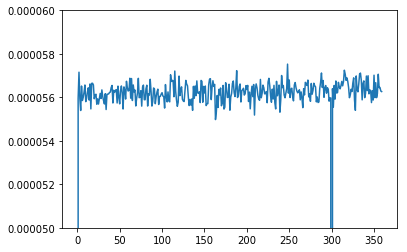

In [319]:
plt.plot(line_irradiance[:, 3])
plt.ylim(5e-5, 6e-5)

In [341]:
df = pd.DataFrame(line_irradiance,columns=wavelengths)

In [339]:
print(len(df))
df.head()

360


,9.392600059509277,13.12399959564209,13.28499984741211,17.10700035095215,17.724300384521484,18.040700912475586,19.511999130249023,20.20439910888672,21.133100509643555,25.63170051574707,...,71.85350036621094,72.15599822998047,77.04090118408203,79.0198974609375,83.55000305175781,94.97000122070312,97.25370025634766,97.7030029296875,102.5719985961914,103.19000244140625
0,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.00000,-1.000000,-1.00000,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.000004,0.000002,7.554066e-07,0.000056,0.000036,0.00005,0.000037,0.00003,0.000017,0.000030,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.000004,0.000002,7.535070e-07,0.000057,0.000037,0.00005,0.000037,0.00003,0.000017,0.000030,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.000004,0.000002,7.084093e-07,0.000056,0.000037,0.00005,0.000036,0.00003,0.000018,0.000031,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.000004,0.000002,7.334931e-07,0.000055,0.000036,0.00005,0.000037,0.00003,0.000017,0.000030,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [174]:
# sunpy read in.. the [2] is just a point in time
tai = data[2][0]
yyyydoy = data[2][1]
sod = data[2][2]
flags = data[2][3]
sc_flags = data[2][4]
line_irradiance = data[2][5]
line_precision = data[2][6]
line_accuracy = data[2][7]
band_irradiance = data[2][8]
band_precision = data[2][9]
band_accuracy = data[2][10]
diode_irradiance = data[2][11]
diode_stdev = data[2][12]
diode_precision = data[2][13]
diode_accuracy = data[2][14]
quad_fraction = data[2][15]
quad_stdev = data[2][16]
quad_precision = data[2][17]
quad_accuracy = data[2][18]

# Figuring out how sunpy timeseries stores its data

In [17]:
import sunpy.timeseries
import sunpy.data.sample
lyra = sunpy.timeseries.TimeSeries(sunpy.data.sample.LYRA_LEVEL3_TIMESERIES)

In [18]:
type(lyra)

sunpy.timeseries.sources.lyra.LYRATimeSeries

In [28]:
lyra.data.head()

,CHANNEL1,CHANNEL2,CHANNEL3,CHANNEL4
2011-06-07 00:00:00.010,0.006365,0.695866,0.002392,0.001100
2011-06-07 00:01:00.010,0.006365,0.695868,0.002392,0.001100
2011-06-07 00:02:00.010,0.006366,0.695870,0.002391,0.001100
2011-06-07 00:03:00.010,0.006366,0.695870,0.002391,0.001099
2011-06-07 00:04:00.010,0.006365,0.695873,0.002391,0.001099


In [29]:
rhessi = sunpy.timeseries.TimeSeries(sunpy.data.sample.RHESSI_TIMESERIES)

In [31]:
rhessi.data.head()

,3 - 6 keV,6 - 12 keV,12 - 25 keV,25 - 50 keV,50 - 100 keV,100 - 300 keV,300 - 800 keV,800 - 7000 keV,7000 - 20000 keV
2011-06-07 00:00:00,9,18,15,20,48,136,112,88,3
2011-06-07 00:00:04,8,18,16,22,48,136,108,88,4
2011-06-07 00:00:08,8,16,16,20,48,136,112,88,4
2011-06-07 00:00:12,8,20,18,22,48,136,112,88,4
2011-06-07 00:00:16,9,16,15,22,44,136,112,88,4


In [32]:
type(rhdaessi)

sunpy.timeseries.sources.rhessi.RHESSISummaryTimeSeries

In [ ]:
# Optionally average the data

In [ ]:
# Optionally change the missing data flag from -1 to user desired value

In [ ]:
# Return the EVE lines data with any optional modifications
return tbd